This notebook demonstrates the addition of environmental noise to the simulated genetic values to produce final phenotypes, offering two approaches: user-defined noise with explicit mean and covariance parameters, or heritability-based noise where the environmental variance is automatically scaled based on a specified h² value (demonstrated with h² = [0.25, 0.5]). Throughout the workflow, it normalizes the data, splits phenotypes by causal mutation, and validates the results through variance calculations and histograms to confirm that the simulated noise and phenotypes match the expected statistical properties.

In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.split import split_phenotypes


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation. The bash script below will function as expected given the relative path for the source data file is accurate.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct -p 10 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

Processing input file in 10 parts.
Auto-calculating number of trees per part.
Converting segments of input data to graphs
100%|██████████| 10/10 [00:00<00:00, 22.77it/s]
Merging...


In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = np.zeros(2)
cov_1 = np.eye(2) 
model_normal_multi = grg_causal_mutation_model("multivariate normal", mean=mean_1, cov=cov_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal_multi.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [[ 1.88658492 -0.09555932]
 [ 2.6735559   0.80222239]
 [-0.31029932  1.49288009]
 ...
 [-1.51766666  0.35896033]
 [ 1.88368526  0.6821456 ]
 [-0.46657918 -0.34573403]]


In [5]:
trait_df_normal_multi = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal_multi, random_seed=1)
sample_nodes_df_multi = additive_effect_sizes(grg_1, trait_df_normal_multi)
individuals = samples_to_individuals(sample_nodes_df_multi)
normalized_individual_multi_normal = normalize_genetic_values(individuals)


First, we will demonstrate how to simulate user-defined noise for multiple causal mutations (if the user does not want to use the h2 heritability feature). In this case, the user must specify the mean and covariance matrix to be used.

In [6]:
std_means = np.array([0, 0])
std_covariances = np.array([[1, 0], [0, 1]])
phenotypes_user_defined_multi_normal = sim_env_noise(individuals, user_defined=True, means=std_means, cov=std_covariances) #simulates noise from the multivariate standard normal distribution with means of zero and an identity matrix for covariance
phenotypes_user_defined_multi_normal_df = phenotypes_user_defined_multi_normal.phenotype_df
phenotypes_user_defined_multi_normal_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.226054,-37.716326
1,1,0,-23.087706,-1.277445,-24.365151
2,0,1,-19.908226,-0.526460,-20.434686
3,1,1,-22.240029,-0.226555,-22.466584
4,0,2,-9.933216,-2.088282,-12.021499
...,...,...,...,...,...
395,1,197,6.632294,0.134778,6.767073
396,0,198,-28.121344,0.397509,-27.723836
397,1,198,-17.527029,0.542716,-16.984313
398,0,199,-10.601552,-0.792890,-11.394443


The user can extract the h2 assigned to any phenotype simulation as follows.

In [7]:
user_defined_multi_h2 = phenotypes_user_defined_multi_normal.get_h2()
print(user_defined_multi_h2)

[1.00062228 0.99296849]


In [8]:
split_phenotypes(phenotypes_user_defined_multi_normal_df, return_print=True)

     causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379             0.226054   
2                     0              1     -19.908226            -0.526460   
4                     0              2      -9.933216            -2.088282   
6                     0              3     -16.476328            -0.669332   
8                     0              4     -39.004838             0.009944   
..                  ...            ...            ...                  ...   
390                   0            195     -20.002154             0.001190   
392                   0            196     -27.360933             0.959533   
394                   0            197     -23.888838             1.351781   
396                   0            198     -28.121344             0.397509   
398                   0            199     -10.601552            -0.792890   

     phenotype  
0   -37.716326  
2   -20.434686  
4   -12.0214

In [9]:
split_phenotypes_list = split_phenotypes(phenotypes_user_defined_multi_normal_df, return_list=True)
split_phenotypes_list[0] #the first dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.226054,-37.716326
2,0,1,-19.908226,-0.526460,-20.434686
4,0,2,-9.933216,-2.088282,-12.021499
6,0,3,-16.476328,-0.669332,-17.145660
8,0,4,-39.004838,0.009944,-38.994894
...,...,...,...,...,...
390,0,195,-20.002154,0.001190,-20.000964
392,0,196,-27.360933,0.959533,-26.401400
394,0,197,-23.888838,1.351781,-22.537057
396,0,198,-28.121344,0.397509,-27.723836


In [10]:
split_phenotypes_list[1] #the second dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
1,1,0,-23.087706,-1.277445,-24.365151
3,1,1,-22.240029,-0.226555,-22.466584
5,1,2,-30.900956,-1.463896,-32.364853
7,1,3,-27.909054,-0.314132,-28.223185
9,1,4,10.082859,-0.714253,9.368607
...,...,...,...,...,...
391,1,195,0.216175,-0.577695,-0.361520
393,1,196,-26.683542,-2.523864,-29.207405
395,1,197,6.632294,0.134778,6.767073
397,1,198,-17.527029,0.542716,-16.984313


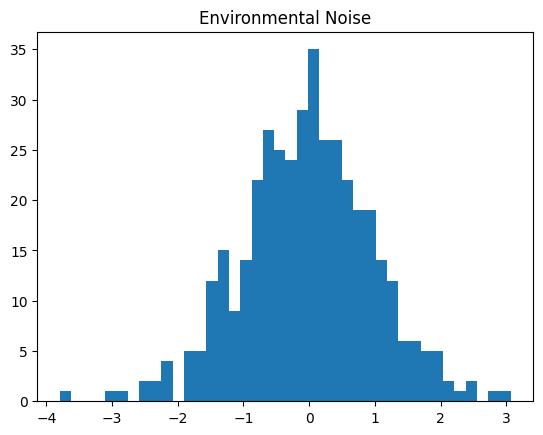

Mean of noise: -0.029715667288332828
Standard deviation of noise: 0.9971549553159531


In [11]:

plt.hist(phenotypes_user_defined_multi_normal_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].std()))

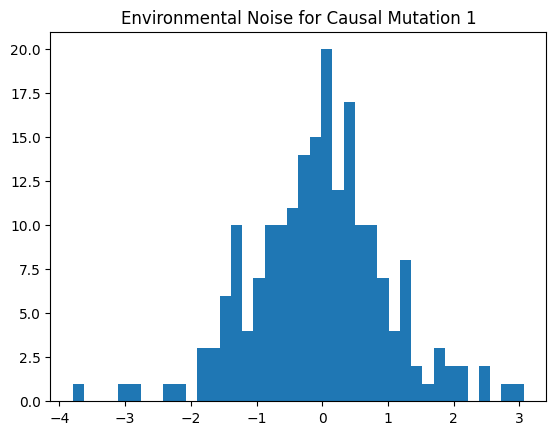

Mean of noise: -0.03856701482863899
Standard deviation of noise: 1.0364780595620888


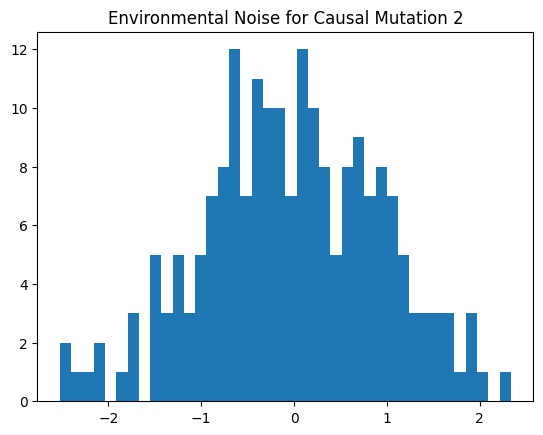

Mean of noise: -0.02086431974802665
Standard deviation of noise: 0.9587431014878985


In [12]:
df_dict_test = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_df.groupby('causal_mutation_id')}

num = len(df_dict_test)

for i in range(num):
  temp_df = df_dict_test[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [13]:
phenotypes_user_defined_multi_normal_df_normalized = normalize(phenotypes_user_defined_multi_normal)
phenotypes_user_defined_multi_normal_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.466111,0.025135,-1.440976
1,1,0,-0.973550,-0.104904,-1.078454
2,0,1,0.246842,-0.046342,0.200500
3,1,1,-0.902783,-0.017172,-0.919955
4,0,2,1.194306,-0.194690,0.999616
...,...,...,...,...,...
395,1,197,1.507575,0.012994,1.520569
396,0,198,-0.533272,0.041420,-0.491851
397,1,198,-0.509326,0.047050,-0.462277
398,0,199,1.130825,-0.071649,1.059176


In [14]:
means = np.array([0, 0])
covariance = np.array([[1, 0.25], [0.25, 1]])
phenotypes_user_defined_multi_normal_special_cov = sim_env_noise(individuals, user_defined=True, means=means, cov=covariance) #simulating noise using a user-defined covariance matrix instead of the identity matrix
phenotypes_user_defined_multi_normal_special_cov_df = phenotypes_user_defined_multi_normal_special_cov.phenotype_df
phenotypes_user_defined_multi_normal_special_cov_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,-0.087954,-38.030333
1,1,0,-23.087706,0.181675,-22.906031
2,0,1,-19.908226,-0.374258,-20.282485
3,1,1,-22.240029,0.203424,-22.036605
4,0,2,-9.933216,-1.543955,-11.477171
...,...,...,...,...,...
395,1,197,6.632294,-0.347870,6.284424
396,0,198,-28.121344,-0.126586,-28.247930
397,1,198,-17.527029,0.822541,-16.704488
398,0,199,-10.601552,0.630447,-9.971105


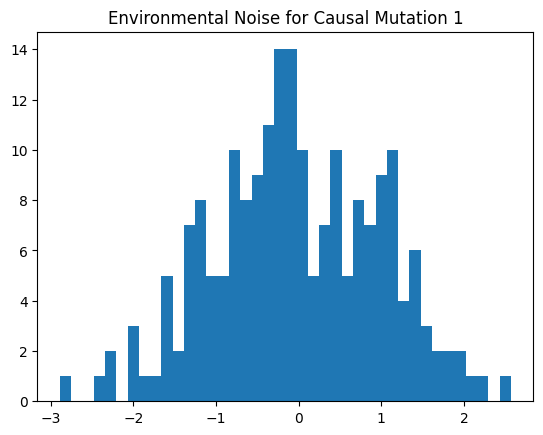

Mean of noise: -0.030389645843499905
Standard deviation of noise: 1.0138150005493922


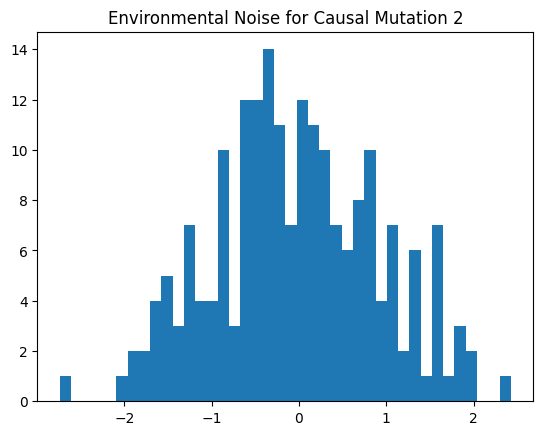

Mean of noise: -0.033182226160549985
Standard deviation of noise: 0.9468989384780946


In [15]:
df_dict_test_cov = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_special_cov_df.groupby('causal_mutation_id')}

num = len(df_dict_test_cov)

for i in range(num):
  temp_df = df_dict_test_cov[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [16]:
phenotypes_user_defined_multi_normal_special_cov_df_normalized = normalize(phenotypes_user_defined_multi_normal_special_cov, normalize_genetic_values=True)
phenotypes_user_defined_multi_normal_special_cov_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.474201,-0.005498,-1.479699
1,1,0,-0.974420,0.017953,-0.956467
2,0,1,0.248204,-0.032842,0.215362
3,1,1,-0.903590,0.019770,-0.883820
4,0,2,1.200897,-0.144558,1.056339
...,...,...,...,...,...
395,1,197,1.508923,-0.026295,1.482628
396,0,198,-0.536214,-0.009188,-0.545402
397,1,198,-0.509781,0.071503,-0.438279
398,0,199,1.137065,0.063115,1.200180


In [17]:
phenotypes_zero_noise = sim_env_noise(individuals) #simulates zero noise (assumes h2 is an array of 1s)
phenotypes_zero_noise_df = phenotypes_zero_noise.phenotype_df
phenotypes_zero_noise_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.0,-37.942379
1,1,0,-23.087706,0.0,-23.087706
2,0,1,-19.908226,0.0,-19.908226
3,1,1,-22.240029,0.0,-22.240029
4,0,2,-9.933216,0.0,-9.933216
...,...,...,...,...,...
395,1,197,6.632294,0.0,6.632294
396,0,198,-28.121344,0.0,-28.121344
397,1,198,-17.527029,0.0,-17.527029
398,0,199,-10.601552,0.0,-10.601552


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have not yet been normalized).

In [18]:
phenotype_multi_normal_h2 = sim_env_noise(individuals, h2=[0.5, 0.75]) #simulating environmental noise for 2 causal mutations without normalizing genetic values
phenotype_multi_normal_h2_df = phenotype_multi_normal_h2.phenotype_df
phenotype_multi_normal_h2_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,2.313934,-35.628445
1,1,0,-23.087706,0.184599,-22.903107
2,0,1,-19.908226,-17.723729,-37.631955
3,1,1,-22.240029,-4.148598,-26.388627
4,0,2,-9.933216,-4.163481,-14.096698
...,...,...,...,...,...
395,1,197,6.632294,1.340973,7.973267
396,0,198,-28.121344,-8.447722,-36.569066
397,1,198,-17.527029,4.626539,-12.900490
398,0,199,-10.601552,-10.273431,-20.874983


In [19]:
print(phenotype_multi_normal_h2.get_h2()) #printing the h2 used for the simulation

[0.5, 0.75]


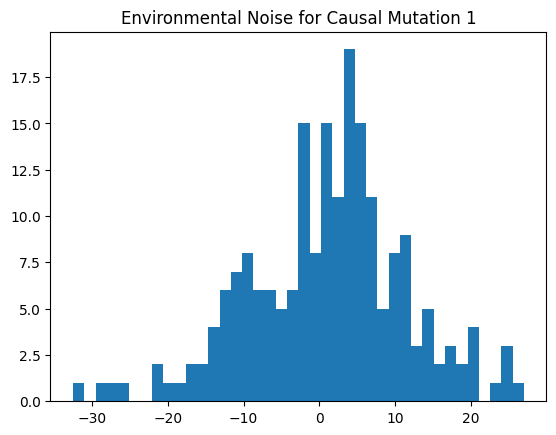

Mean of noise: 1.077995581043341
Standard deviation of noise: 10.516413574518943


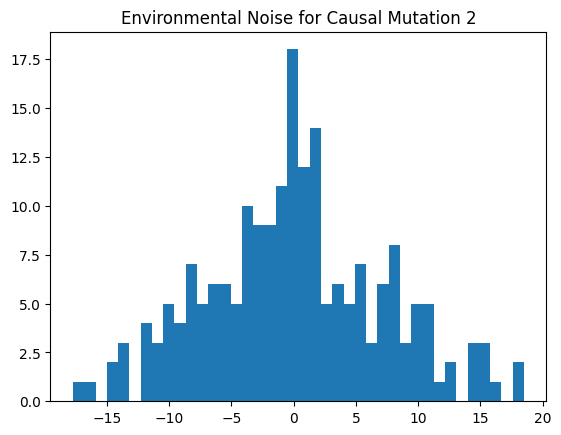

Mean of noise: 0.055870157072086285
Standard deviation of noise: 7.192683738956424


In [20]:
df_dict_test_pre_normal = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal)

for i in range(num):
  temp_df = df_dict_test_pre_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [21]:
phenotype_multi_normal_h2_df_normalized = normalize(phenotype_multi_normal_h2, normalize_genetic_values=True)
phenotype_multi_normal_h2_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.104112,0.088408,-1.015704
1,1,0,-0.834271,0.009209,-0.825062
2,0,1,0.185894,-1.344911,-1.159018
3,1,1,-0.773628,-0.300788,-1.074416
4,0,2,0.899419,-0.374930,0.524489
...,...,...,...,...,...
395,1,197,1.291897,0.091936,1.383833
396,0,198,-0.401601,-0.681387,-1.082988
397,1,198,-0.436460,0.326985,-0.109475
398,0,199,0.851612,-0.811982,0.039630


In [22]:
df_dict_test_pre_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df_normalized.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal_final)

for i in range(num):
  temp_df = df_dict_test_pre_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 1.0000000000000002
Variance of the genetic values for Causal Mutation 1 is 0.5619995540837981
Variance of the noise for Causal Mutation 1 is 0.5658838377467449
Variance of the phenotypes for Causal Mutation 2 is 1.0000000000000002
Variance of the genetic values for Causal Mutation 2 is 0.7244730923099187
Variance of the noise for Causal Mutation 2 is 0.2647765156583035


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have already been normalized).

In [23]:
phenotype_post_normalization = sim_env_noise(normalized_individual_multi_normal, h2=[0.25, 0.45]) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization = phenotype_post_normalization.phenotype_df
phenotype_df_post_normalization

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.472805,-1.097387,-2.570192
1,1,0,-0.980158,-1.558264,-2.538422
2,0,1,0.247969,-0.801138,-0.553170
3,1,1,-0.908911,-0.715022,-1.623933
4,0,2,1.199759,2.787553,3.987313
...,...,...,...,...,...
395,1,197,1.517808,-0.187889,1.329919
396,0,198,-0.535707,-0.630228,-1.165934
397,1,198,-0.512783,0.273163,-0.239620
398,0,199,1.135988,-1.835453,-0.699465


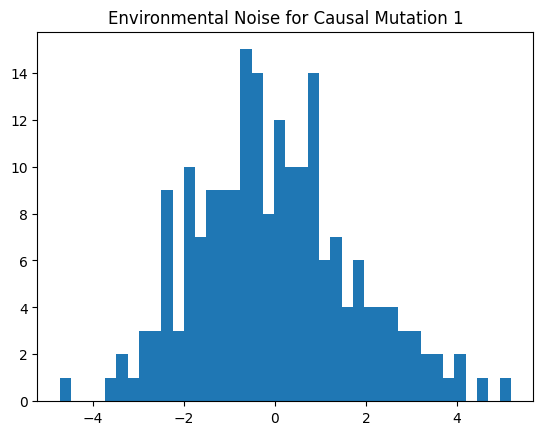

Mean of noise: -0.0068033070336853555
Standard deviation of noise: 1.7444159247924396


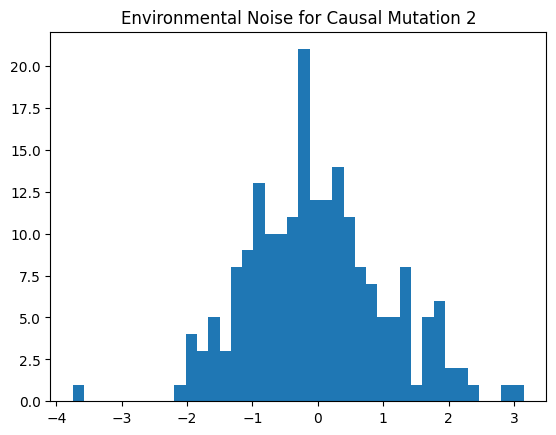

Mean of noise: -0.010060277886845942
Standard deviation of noise: 1.0577791138967185


In [24]:
df_dict_test_post_normal = {k: v.sort_values('individual_id') for k, v in phenotype_df_post_normalization.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal)

for i in range(num):
  temp_df = df_dict_test_post_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_final_df = normalize(phenotype_post_normalization) #normalizing the final dataframe with the phenotypes
phenotype_post_normalization_final_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.720378,-0.533426,-1.253804
1,1,0,-0.654318,-1.033525,-1.687843
2,0,1,0.121286,-0.388525,-0.267238
3,1,1,-0.606756,-0.470607,-1.077363
4,0,2,0.586826,1.366775,1.953601
...,...,...,...,...,...
395,1,197,1.013233,-0.118712,0.894521
396,0,198,-0.262025,-0.304929,-0.566954
397,1,198,-0.342315,0.189069,-0.153246
398,0,199,0.555634,-0.894429,-0.338794


In [26]:
df_dict_test_post_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_post_normalization_final_df.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal_final)

for i in range(num):
  temp_df = df_dict_test_post_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 0.9999999999999999
Variance of the genetic values for Causal Mutation 1 is 0.23923811690161784
Variance of the noise for Causal Mutation 1 is 0.7279984601787384
Variance of the phenotypes for Causal Mutation 2 is 1.0
Variance of the genetic values for Causal Mutation 2 is 0.44564139666085023
Variance of the noise for Causal Mutation 2 is 0.49862666751685786
